# Project 2

By Rahul Bajaj and Charbel El Feghali

In [1]:
import numpy as np
from matplotlib import image
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy import ndimage
from skimage import color
import matplotlib.patches as patches
import cv2
import os
from sklearn.cluster import KMeans
%matplotlib inline
import torch
import torch.nn as nn 
import torch.optim as optim
import random
import open3d as o3d
from array import array


#for tensor flow
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from PIL import Image
from IPython.display import display
import pathlib
matplotlib.rcParams['figure.figsize'] = (16, 20)

We start by defining a few helper functions to be used throughout the notebook. 

This one computes the magnitude of an image by convolving the derivative filters.

In [2]:
def magnitude(img):
    
    # Initializing filters and matrices
    dx = np.array([[-1, 1]])
    dy = np.array([[-1], [1]])
    m, n, c = img.shape
    square = np.zeros((m, n))
    
    # Loop through colour channels
    for i in range(c):
        grad_x = signal.convolve2d(img[:, :, i], dx, boundary='symm', mode='same')
        grad_y = signal.convolve2d(img[:, :, i], dy, boundary='symm', mode='same')
        square += grad_x**2 + grad_y**2
    
    return np.sqrt(square)

These two create the Laplacian of Gaussians filter up to a given sigma.

In [3]:
def LoG(u, v, sigma):
    t1 = -1 / (np.pi * sigma**4)
    t2 = 1 - ((u**2 + v**2) / (2 * sigma**2))
    t3 = np.exp(-(u**2 + v**2) / (2 * sigma**2))
    
    return t1 * t2 * t3

def create_LoG_filter(sigma):
    n = round(6 * sigma)
    if (n%2 == 0):
        n += 1
    k = (n - 1) / 2
    F = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            F[i, j] = LoG(i - k, j - k, sigma)
    return F

We start by loading the images from the training set into a dictionary to be accessed throughout the notebook. 

The function can also compute the magnitude and Laplacian of Gaussians for each image and return seperate dictionnaries for each.

In [4]:
def load_images(d, plot=False, get_mag=False, get_LoG=False):
    
    # Initialize dictionnaries
    imgs, mags, LoG = {}, {}, {}
    
    # Loop through the given directory
    for filename in sorted(os.listdir(d)):
        
        # If the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            
            # Read the image using opencv and extract the image number
            img = cv2.imread(os.path.join(d, filename))
            num = filename.split(".")[0]
            imgs[num] = img
            
            # Compute magnitude if specified
            if get_mag:
                mags[num] = magnitude(img)
                
            # Compute Laplacian of Gaussians if sepcified
            if get_LoG:
                LoG[num] = signal.convolve2d(img[:, :, 0], create_LoG_filter(1),
                                             boundary='symm', mode='same')
            
            # Plot the image if specified
            if plot:
                plt.imshow(img[:, :, ::-1])
                plt.title(num)
                plt.show()

    return imgs, mags, LoG

In [5]:
# Loading images from the training set
left_imgs, mags, LoGs = load_images("./project2/train/image_left", get_mag=True, get_LoG=True)
right_imgs, _, _ = load_images("./project2/train/image_right")

Now that we have dictionaries containing left and right images, as well as the magnitudes and LoGs of the left images, we can start with the first task.

To see what we are working with, let's visualize one pair of left and right images.

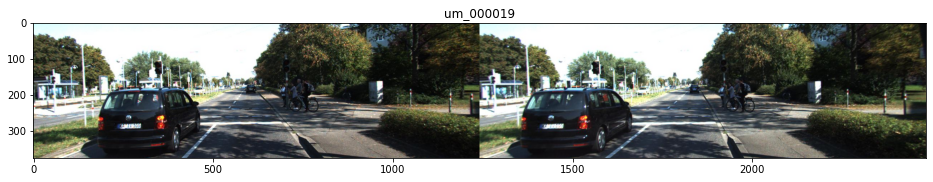

In [46]:
num = "um_000019"
left = left_imgs[num]
right = right_imgs[num]
both = np.concatenate((left, right), axis=1)

plt.imshow(both[:, :, ::-1])
plt.title(num)
plt.show()

As well as the magnitude

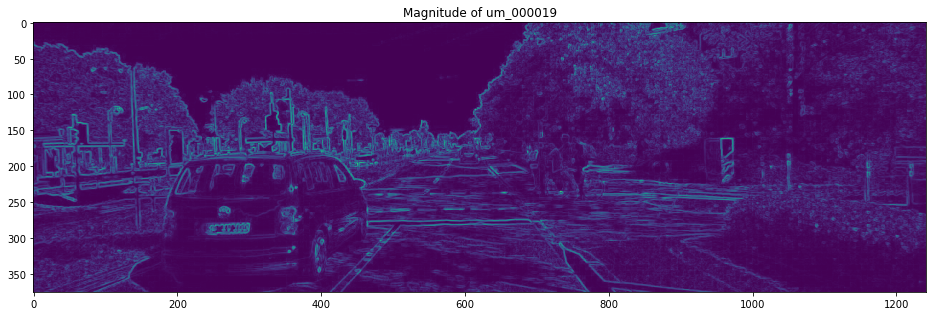

In [7]:
# Visualizing magnitude
plt.imshow(mags[num])
plt.title("Magnitude of " + num)
plt.show()

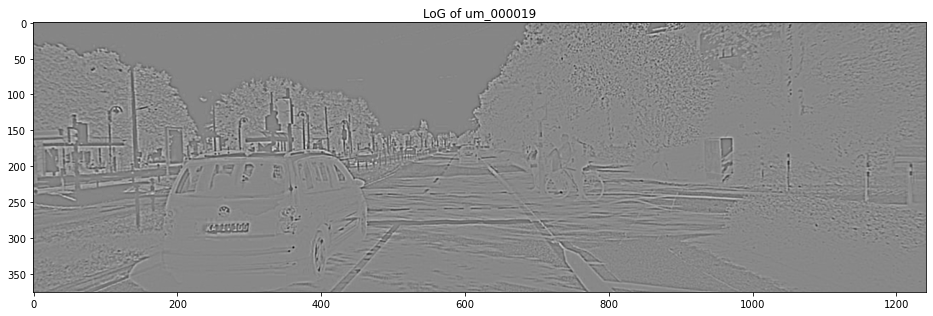

In [8]:
# Visualizing LoG
plt.imshow(LoGs[num], cmap=plt.cm.gray)
plt.title("LoG of " + num)
plt.show()

Finally, before we begin, we check if a GPU is available for use (models were trained on Google Colab)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Part 1) Computing disparity between two stereo images

Worked on by Rahul

Since all cameras have the same parameters, we set their values to be used throughout the notebook.

In [10]:
f = 721.537700
px = 609.559300 
py = 172.854000 
baseline = 0.5327119288*1000

K = np.array([
              [f, 0, px],
              [0, f, py],
              [0, 0, 1]    
])

To compute disparty between two stereo images, we chose to use the function cv2.StereoSGBM_create() which uses a modified implementation of the Semi-Global Matching algorithm proposed by Heiko Hirschmuller to compute accurate and efficient disparity maps. We chose to use this algorithm over a normal block-based approach as described in lecture because this algorithm has the ability to produce a more dense and smooth disparity map which is favoured for 3D reconstruction and point clouds. This algorithm is similar to other block-based algorithms in the sense that, each rectified pixel from the left image is found along the epipolar scanline of the right image. What makes SGBM unique is that the algorithm also uses information from the neighboring pixels in multiple directions (usually 8 directions around the neighbouring pixels) to calculate the disparity of a given pixel.\
\
One drawback of this algorithm is how it uses disparity levels to find the corresponding left pixel on the scanline of the right image. For every pixel in the left image, the algorithm searches for the corresponding pixel among $D$ pixels in the right image, where $D$ is a parameter that initializes the disparity level. Because of this, the first $D$ columns within the left image are unused and ignored since those pixel values cannot be compared within the right image, resulting in a black vertical bar on the disparity map that cuts the image.

<img src="./SGBM_DisparityLevels.png">

Coming back to cv2.StereoSGBM_create(), the disparity levels within the algorithm is controlled by the "numDisparities" parameter, which in our case is set to 192. This means that the first 192 columns within our left stereo image is ignored. This specific algorithm only uses 5 directions around neighbouring pixels to calculate disparity and block matches using the "blockSize" parameter. Pixel matching is also possible within this algorithm when "blockSize" is set to 1.

In [11]:
def compute_disparity(imgL, imgR, num_disp=164):
    
    stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disp,
                                  blockSize= 7,
                                  uniquenessRatio = 1,
                                  speckleWindowSize = 150,
                                  speckleRange = 2,
                                  disp12MaxDiff = 10,
                                  P1 = 600,
                                  P2 = 2400,
                                  preFilterCap = 4)
    disparity = stereo.compute(imgL, imgR)
    normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return normalized

As you can observe by the visualization below, the disparity map computed from two stereo images appears quite smooth and accurate. There is some noticible noise within the disparity map due to fine-tuning issues within the parameters of the disparity function. Since "numDisparities" was set to 192, we can observe that the first 192 columns are ignored. We could have resolved this issue by implementing our own function to compute disparity maps, but it would have resulted in a lot less accurate and noisy maps.

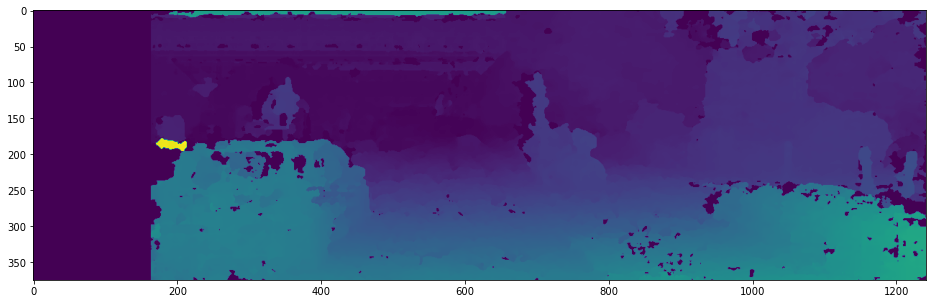

In [12]:
# Visualizing disparity with num_disparities=192
d = compute_disparity(left[:, :, 0], right[:, :, 0])
plt.imshow(d)
plt.show()

## Part 2) Computing depth of each pixel and finding 3D coordinates

Worked on by Rahul

In order to calculate the depth map, we used the disparity map from above and the intrinsic camera parameters to compute depth for each pixel, where:
$$ Depth = \frac{f*T}{x_{r}-x_{l}}$$ where $f$ is the focal length in mm, $T$ is the baseline in mm and $x_{r}-x_{l}$ is the disparity.

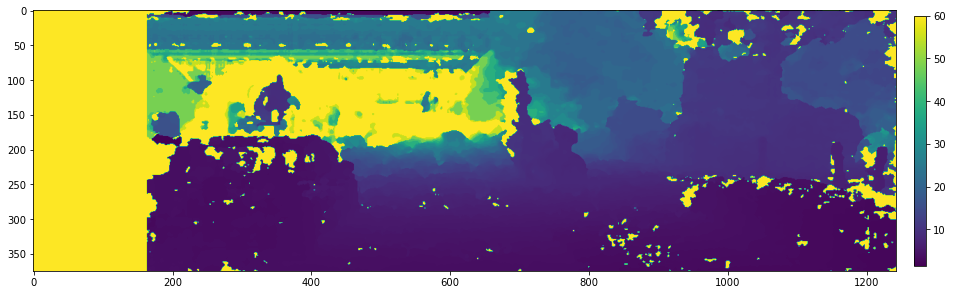

In [13]:
def get_depth(disparity):
    
    # Replace 0 disparity with small value
    disparity = np.where(disparity==0, 0.001, disparity)
    
    # Compute depth
    depth = f*baseline/disparity
    
    # If the depth is too large, cap its value
    return np.where(depth > 60000, 60000, depth)

# Computing depth map
depth = get_depth(d)

# Visualizing depth map wih color bar in meters
im = plt.imshow(depth/1000)
plt.colorbar(im, fraction=0.014, pad=0.02)
plt.show()

We compute the 3D points in the part 4) section of this project since we modified it to help fit the road plane.

## Part 3) Training a road classifier that computes road pixels in an image

Worked on by Charbel

Since we have labels, this is a supervised learning task. Our first step is to load them in.

Our classifier will have to predict whether a pixel belongs to the road, or not. This is a binary classification task where 0 will signify that the pixel does not belong to the road and 1 that it does.

Our loaded labels contain values that are either 0 or 255, so we will need to divide every entry by 255 to have our desired classes 0 and 1.

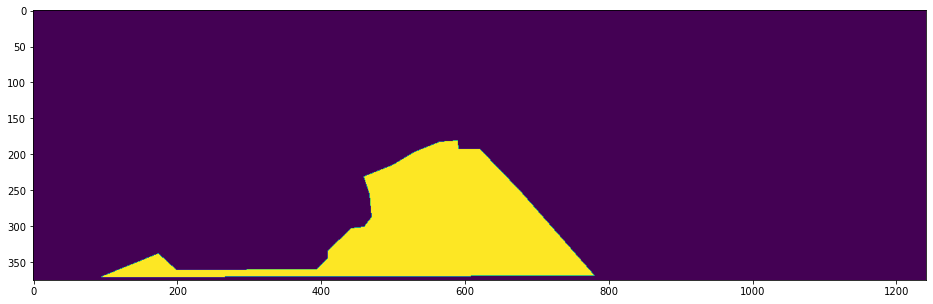

In [14]:
# Loading our labels
gt_road, _, _ = load_images("./project2/train/gt_image_left")

# Picking a label to test and visualize
test = gt_road["um_road_000019"]

# Gettin desired classes
img_gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)//255

# Visualizing label
plt.imshow(img_gray[:, :])
plt.show()

One feature of our input will be the depth map of the image, so we first create a dictionary containing the depth maps for all images.

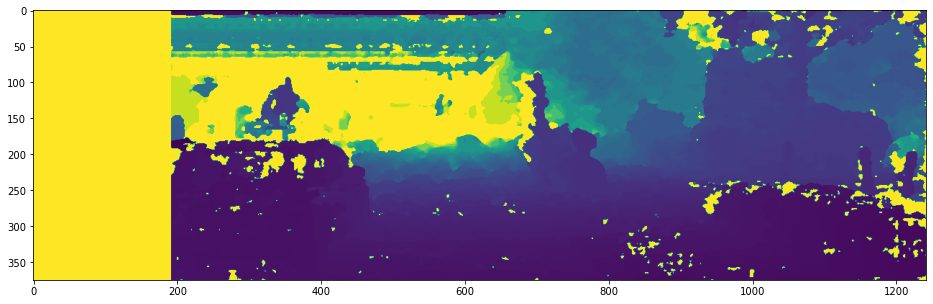

In [15]:
# Computing depth map for all images in our dataset
depths = {}
for key, imgL in left_imgs.items():
    imgR = right_imgs[key]
    depths[key] = get_depth(compute_disparity(imgL[:, :, 0], imgR[:, :, 0], num_disp=192))

# Visualizing an element in the dictionnary
plt.imshow(depths[num])
plt.show()

Now that the labels and depth maps are loaded in, we can train a classifier. 

For this part of the project, we explored two different apporaches

### Attempt #1   
### CNN Patch Classification

For this approach, we are going to use a convolutional neural network that takes in a patch of the image and features, and outputs whether or not the center pixel is a road pixel.

Let $k$ be our patch size. For each image, we extract multiple $k \times k$ patches where the center of each patch is the pixel to be classified.

Instead of having a single output unit and using binary cross entropy loss, we opted to have 2 output units and to use multi class cross entropy loss to give the network more capacity.

Here is a diagram of our CNN architecture:

<img src="./patchcnn.png">

We define the class for our classifier using PyTorch

In [29]:
class PatchCNN(nn.Module):
    def __init__(self, n=6):
        super(PatchCNN, self).__init__()
                
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=n,
                               kernel_size=5,
                               padding=2)
                
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=n, 
                               out_channels=n*2, 
                               kernel_size=5, 
                               padding=2)
                
        self.conv3 = nn.Conv2d(in_channels=n*2, 
                               out_channels=n*4,
                               kernel_size=5,
                               padding=2)
        
        
        self.fc1 = nn.Linear(n*4*6*6, 100)
        self.fc2 = nn.Linear(100, 2)
        
        
    def forward(self, x):
        
        x = self.pool(torch.relu(self.conv1(x)))        
        x = self.pool(torch.relu(self.conv2(x)))        
        x = torch.relu(self.conv3(x))        
        x = x.view(-1, self.n*4*6*6)
        x = torch.relu(self.fc1(x))
        x = x.view(-1, 100)
        return self.fc2(x)

We now need to create the patches dataset. 

By looking through the labels, we noticed that most pixels are non-road pixels, so to stop the neural network from always outputting 0 to achieve high accuracy, we need to create a balanced dataset with a 50/50 split between positive and negative training examples, which is what we do in the get_patches_and_labels() function. We also stack the features along the channel dimension. 

Our features are $[r, g, b, magnitude, LoG, depth map]$

So our input shape must be $(N, 6, k, k)$, where $N$ is the number of datapoints and $k$ our patch size.

This follows the $NCWH$ convention for PyTorch CNNs.


In [17]:
def get_patches_and_labels(desired_label, k=27):
    patches, labels = [], []
    p = k//2
    
    # Loop through all left images
    for key, img in left_imgs.items():
        if img.shape == (375, 1242, 3) and key != "um_000000":
            already_collected = []
            collected = 0
            
            # Getting the labels for the current image
            split = key.split("_")
            split.insert(1, "road")
            
            # Dividing by 255 to get the desired classes as discussed above
            target = cv2.cvtColor(gt_road["_".join(split)], cv2.COLOR_BGR2GRAY)//255
            
            # Getting all of our features and normalizing them to the same range
            img = (img/255) - 0.5
            mag = mags[key]
            mag = (mag/np.max(mag)) - 0.5
            LoG = LoGs[key]
            LoG = (LoG/np.max(LoG)) - 0.5
            depth = depths[key]
            depth = (depth/np.max(depth)) - 0.5
            
            # Stacking along the channel dimension
            features = np.dstack((img, mag, LoG, depth))
            
            # We want to collect 1000 datapoints per image
            while collected < 1000:
                m, n, _ = img.shape
                
                # Randomly sampling the image for a center pixel and its correspondingg label
                i = random.randint(p, m-p-1)
                j = random.randint(p+64, n-p-1)
                patch = features[i-p:i+p+1, j-p:j+p+1, :]
                label = target[i,j]
                
                # Keep sampling if we already collected the sampled point or if its label
                # is not what we are looking for
                while (i, j) in already_collected or label != desired_label:
                    i = random.randint(p, m-p-1)
                    j = random.randint(p+64, n-p-1)
                    patch = features[i-p:i+p+1, j-p:j+p+1, :]
                    label = target[i,j]
                    
                # Update lists and counters
                already_collected.append((i, j))
                patches.append(patch)
                labels.append(label)
                collected += 1

    return patches, labels

# This gives us our negative training data
neg_patches, neg_labels = get_patches_and_labels(0)

In [18]:
print("Collected", len(neg_labels), "negative data points")

Collected 123000 negative data points


In [19]:
# This gives us our positive training data
pos_patches, pos_labels = get_patches_and_labels(1)
print("Collected", len(pos_labels), "positive data points")

Collected 123000 positive data points


In [20]:
# Testing a forward pass through the CNN
pcnn = PatchCNN()
test = pos_patches[0]
# Reshaping to NCWH
test = np.expand_dims(test, axis=0)
test = np.transpose(test, (0, 3, 2, 1))
print("Input shape:", test.shape)
print("Output shape:", pcnn(torch.Tensor(test)).shape)

# We can see that the output shape matches what we expect

Input shape: (1, 6, 27, 27)
Output shape: torch.Size([1, 2])


In [21]:
neg_patches = np.stack(neg_patches)
pos_patches = np.stack(pos_patches)

In [22]:
pos_labels = np.array(pos_labels)
neg_labels = np.array(neg_labels)

In [23]:
Xpos, Tpos = pos_patches[:110000], pos_labels[:110000]
Xval_pos, Tval_pos = pos_patches[110000:], pos_labels[110000:]

Xneg, Tneg = neg_patches[:110000], neg_labels[:110000]
Xval_neg, Tval_neg = neg_patches[110000:], neg_labels[110000:]

In [24]:
def get_pcnn_accuracy(model, X, T):
    model.eval()
    out = model(X).detach().cpu().numpy()
    classes = np.argmax(out, axis=1)
    return np.mean(classes==T.cpu().numpy())

#### The training code for this CNN was run on google colab to utilize the GPU to decrease training time 

To train this network, we split the data into batches and also kept track of the validation accuracy for the positive and negative examples seperately. The reason for this seperate tracking is to ensure that the model is not blindly outputting all 1's or all 0's.

We also make sure to shuffle the data at every epoch to make sure the model does not learn based on the ordering of the data.

In [ ]:
def train_pcnn(model, Xpos, Xneg, Tpos, Tneg, Xval_pos, Tval_pos, Xval_neg, Tval_neg, batch_size=125, 
               weight_decay=0.0, learning_rate=0.001, num_epochs=55, checkpoint_path=None):
    
    # Defining our loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    # Initializing lists to track performance
    iters, train_loss, val_loss_pos, val_loss_neg = [], [], [], []
    train_accs, val_accs_pos, val_accs_neg = [], [], []
    
    # Moving the model to GPU (if available)
    model = model.to(device)
    
    # Reshaping validationdata to NCWH and moving to GPU (if available)
    Xval_pos = np.transpose(Xval_pos, (0, 3, 2, 1))
    Xval_pos = torch.Tensor(Xval_pos).to(device)
    Tval_pos = torch.Tensor(Tval_pos).long().to(device)
    Xval_neg = np.transpose(Xval_neg, (0, 3, 2, 1))
    Xval_neg = torch.Tensor(Xval_neg).to(device)
    Tval_neg = torch.Tensor(Tval_neg).long().to(device)

    
    # Reshaping and combining positive and negative data into one array
    T = torch.Tensor(np.concatenate((Tpos, Tneg))).to(device)
    X = np.concatenate((Xpos, Xneg))
    X = torch.Tensor(np.transpose(X, (0, 3, 2, 1))).to(device)
  
    n = 0
    for epoch in range(num_epochs):
        
        # Shuffle data at each epoch
        s = np.arange(X.shape[0])
        np.random.shuffle(s)
        X = X[s]
        T = T[s]
        
        # Get new batches
        N, C, W, H = X.shape
        Xbatches = X.reshape(N//batch_size, batch_size, C, W, H)
        Tbatches = T.reshape(N//batch_size, batch_size)

        for i in range(N//batch_size):
            
            # Extract current batch
            batch = Xbatches[i]
            target = Tbatches[i]
            
            # Annotate model for training
            model.train()
            
            # Forward pass 
            out = model(batch)

            # Backpropagation
            loss = criterion(out, target.long())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1
        
        # Compute accuracies
        train_acc = get_pcnn_accuracy(model, X, T)*100
        val_acc_pos = get_pcnn_accuracy(model, Xval_pos, Tval_pos)*100
        val_acc_neg = get_pcnn_accuracy(model, Xval_neg, Tval_neg)*100
        
        # Checkpoint model
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))
    
    
        # Save the current training information
        loss = float(loss)/batch_size
        print("Epoch %d; Loss %f; Train acc %f; Val acc (+) %f; Val acc (-) %f" % (epoch+1, loss, train_acc, val_acc_pos, val_acc_neg))

        iters.append(n)
        train_accs.append(train_acc)
        val_accs_neg.append(val_acc_neg)
        val_accs_pos.append(val_acc_pos)
        train_loss.append(loss)

    # Plotting
    plt.title("Learning Curve") 
    plt.plot(iters, train_loss, label="Train") 
    plt.xlabel("Iterations") 
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Accuracy")
    plt.plot(iters, train_accs, label="Train") 
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy") 
    plt.show()

    plt.title("Validation Accuracy")
    plt.plot(iters, val_accs_neg, label="Train") 
    plt.plot(iters, val_accs_pos, label="Validation") 
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy") 
    plt.show()

cnn = PatchCNN()
train_pcnn(cnn, Xpos, Xneg, Tpos, Tneg, Xval_pos, Tval_pos, Xval_neg, Tval_neg, 
            checkpoint_path='/content/gdrive/My Drive/CSC420/road_classifier_weights/ckpt-{}.pk')

In [30]:
# Loading checkpointed parameters 
road_classifier = PatchCNN()
road_classifier.load_state_dict(torch.load('./road_classifier_weights/ckpt-59.pk', map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
def predict_pixels(model, num, k=27, plot=True):
    
    # Getting the features and normalizing
    image = left_imgs[num]
    mag = mags[num]
    LoG = LoGs[num]
    depth = depths[num]
    image = (image/255) - 0.5
    mag = (mag/np.max(mag)) - 0.5
    LoG = (LoG/np.max(LoG)) - 0.5
    depth = (depth/np.max(depth)) - 0.5
    features = np.dstack((image, mag, LoG, depth))
    m, n, _ = features.shape
    
    # Finding the amount to pad
    p = k//2
    
    # Reshaping to NCWH
    features = np.pad(features, [(p, p), (p, p), (0, 0)], mode='constant', constant_values=0)    
    features = np.expand_dims(features, axis=0)
    features = np.transpose(features, (0, 3, 2, 1))

    pred = np.zeros((m, n))
    road_pixels = []
    
    # Predicting the class for each pixel
    for i in range(p, m+p):
        for j in range(p, n+p):
            
            patch = features[:, :, j-p:j+p+1, i-p:i+p+1]
            out = model(torch.Tensor(patch))
            val = out.argmax().item()
            pred[i-p, j-p] = val
            if val == 1:
                road_pixels.append((i-p, j-p))
    
    if plot:
        plt.imshow(pred)
        plt.title("Predicted road pixels")
        plt.show()

    return pred, road_pixels

Now that the model is trained, we can visualize how it performs on the initial image we were looking at at the start of the notebook.

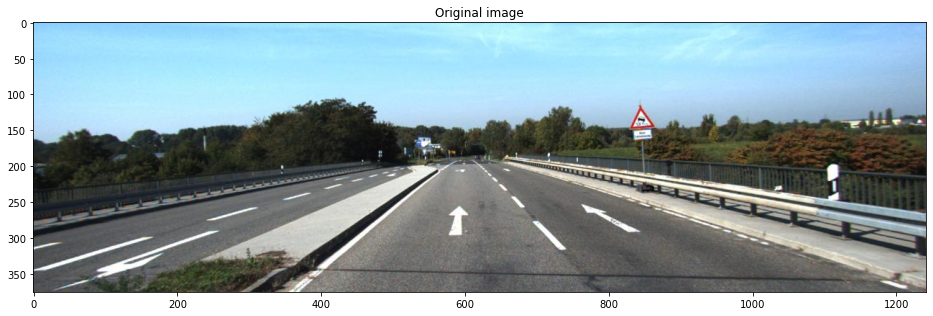

In [32]:
plt.imshow(left_imgs["umm_000011"][:, :, ::-1])
plt.title("Original image")
plt.show()

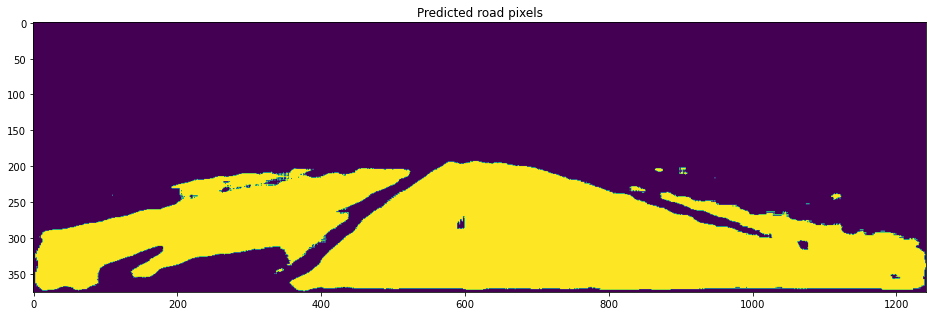

In [33]:
num = "umm_000011"
pred, road_pixels = predict_pixels(road_classifier, num)

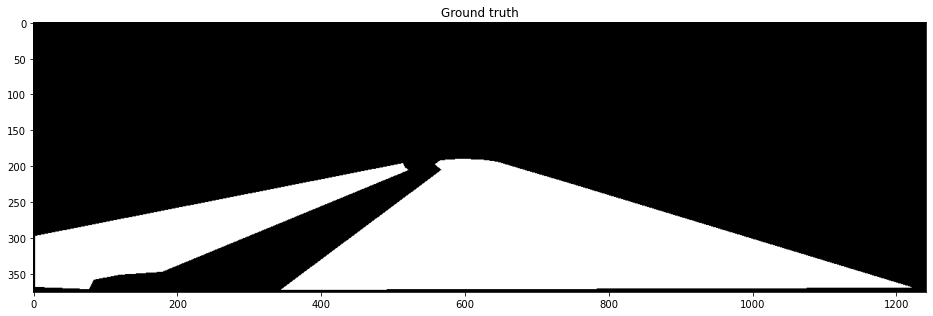

In [35]:
plt.imshow(gt_road['umm_road_000011'])
plt.title("Ground truth")
plt.show()

We can see that the CNN's output is quite noisy, however, it is able to identify most of the road. It seems to also mistake the sidewalk for the road, which would be highly problematic in a real self-driving car. Moreover, getting a prediction for a single image is very computationally expensive and takes a couple of minutes to run. This could be improved with vectorization but would still be too slow for any hope of real time performance.

To further improve accuracy, we wanted to modify the data collection process to include patches whose center pixels are keypoints from the SIFT algorithm. However, we opted for fully convolutional networks as this would greatly speed up our prediction time, and potentially improve accuracy, which brings us to our second attempt below.

### Attempt #2   
### Fully Convolutional Network

To understand FCNs, we consulted the following source:

https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b#:~:text=FCN%20is%20a%20network%20that,connected%20layers%20(Dense%20layers) by Himanshu Rawlani (2020)

A fully convolutional network does not have the dense fully connected layer found in MLPs, instead, they only contain convolutional layers.

This allows the output of the network to have the same width and height as the input. As an added benefit, we can give it an image of any size as input.

Here is a diagram of our architecture, the shapes written are valid if the input size is $(N, 6, 1240, 248)$
<img src="./fcn.png">

Here is the class of the FCN, implemented in PyTorch

In [36]:
class FCN(nn.Module):
    def __init__(self, n=6):
        super(FCN, self).__init__()
                
        self.n = n
        self.leaky_relu = nn.LeakyReLU()

        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=n,
                               kernel_size=5,
                               padding=2) 
          
        self.pool = nn.MaxPool2d(2, 2) 

        self.conv2 = nn.Conv2d(in_channels=n, 
                               out_channels=n*2, 
                               kernel_size=5, 
                               padding=2)


        self.conv3 = nn.Conv2d(in_channels=n*2, 
                               out_channels=n*2, 
                               kernel_size=5, 
                               padding=2)
        
        self.pool = nn.MaxPool2d(2, 2) 
                
        self.conv4 = nn.Conv2d(in_channels=n*2, 
                               out_channels=n*4,
                               kernel_size=5,
                               padding=2) 
        
        self.tconv1 = nn.ConvTranspose2d(in_channels=n*4,
                                         out_channels=n*2,
                                         kernel_size=5,
                                         padding=2,
                                         stride=2,
                                         output_padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=n*2, 
                               out_channels=n*2, 
                               kernel_size=5, 
                               padding=2)
        
        self.tconv2 = nn.ConvTranspose2d(in_channels=n*2,
                                         out_channels=n,
                                         kernel_size=5,
                                         padding=2,
                                         stride=2,
                                         output_padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=n, 
                               out_channels=2, 
                               kernel_size=5, 
                               padding=2)
        
        
    def forward(self, x):
        
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))        
        x = self.leaky_relu(self.conv3(x))        
        x = self.leaky_relu(self.conv4(x))
        x = self.leaky_relu(self.tconv1(x))
        x = self.leaky_relu(self.conv5(x))
        x = self.leaky_relu(self.tconv2(x))
        x = self.conv6(x)
        return x

To train the model, we create another dataset using the same features as the first attempt.

However, to avoid the unbalanced dataset problem, we decided to crop out the top third of the images. The reason for this is that usually the top third of an image is mostly the sky and buildings, which would all have label 0 (the dominant label in the dataset)

In [31]:
def create_data_features():
    
    data, labels = [], []
    
    for key, img in left_imgs.items():
        if img.shape == (375, 1242, 3) and key != "um_000000":
            
            # Getting the targets
            split = key.split("_")
            split.insert(1, "road")
            target = cv2.cvtColor(gt_road["_".join(split)], cv2.COLOR_BGR2GRAY)//255
            
            # Getting the feature 
            img = (left_imgs[key]/255) - 0.5
            mag = mags[key]
            mag = (mag/np.max(mag)) - 0.5
            LoG = LoGs[key]
            LoG = (LoG/np.max(LoG)) - 0.5
            depth = depths[key]
            depth = (depth/np.max(depth)) - 0.5
            
            # Stacking them along the channel dimension and cropping the sky
            features = np.dstack((img, mag, LoG, depth))[127:, 2:, :]
            features = np.transpose(features, (2, 1, 0))
            data.append(features)
            
            # Cropping the sky
            labels.append(target[127:, 2:])

    return np.stack(data), np.stack(labels)

data, labels = create_data_features()

In [32]:
# Splitting validation and training data
fcn_train, fcn_ttrain = data[:110], labels[:110]
fcn_val, fcn_tval = data[110:], labels[110:]

In [33]:
def get_fcn_accuracy(model, X, T):
    model.eval()
    out = model(X).permute(0, 3, 2, 1).reshape(-1, 2)
    pred = out.argmax(dim=1).cpu().numpy()
    t = T.reshape(-1)
    return (pred==t.cpu().numpy()).mean()

Throughout training, let's see how the model evolves and classifies the pixels in this validation data point.

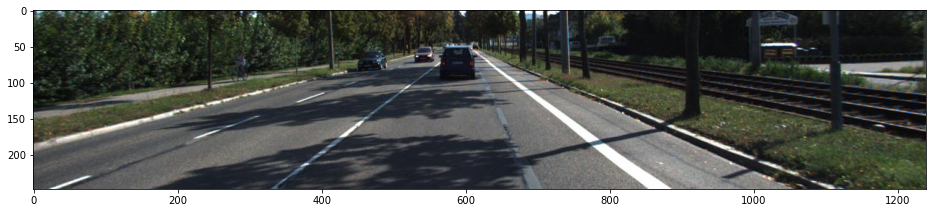

In [34]:
plt.imshow(fcn_val[0].transpose(2, 1, 0)[:, :, :3][:, :, ::-1] + 0.5)

#### The training code for this FCN was run on google colab to utilize the GPU to decrease training time 

In [ ]:
def train_fcn(model, X, T, Xval, Tval, batch_size=10, weight_decay=1e-5,
          learning_rate=0.001, num_epochs=250, checkpoint_path=None):
  
    # Defining our loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) 
    
    # Initializing lists to track performancee
    iters, train_loss, train_accs, val_accs = [], [], [], []
    
    # Sending model and arrays to GPU (if available)
    model = model.to(device)
    X = torch.Tensor(X).to(device)
    T = torch.Tensor(T).long().to(device)
    Xval = torch.Tensor(Xval).to(device)
    Tval = torch.Tensor(Tval).long().to(device)

    n = 0
    for epoch in range(num_epochs):
        
        # Shuffle data at each epoch
        s = np.arange(X.shape[0])
        np.random.shuffle(s)
        X = X[s]
        T = T[s]
        
        # Plot the prediction for the validation image plotted above
        if (epoch % 3 == 0 and epoch <= 15) or (epoch % 10 == 0 and epoch > 20):
            track = model(Xval[0].unsqueeze(dim=0))
            seg = track.argmax(dim=1).permute(2, 1, 0).squeeze().cpu().numpy()
            plt.imshow(seg)
            plt.title("Prediction at epoch " + str(epoch))
            plt.show()
            
        # Split data into batches
        N, C, W, H = X.shape
        Xbatches = X.reshape(N//batch_size, batch_size, C, W, H)
        Tbatches = T.reshape(N//batch_size, batch_size, H, W)

        for i in range(N//batch_size):
            
            # Extract current batch
            batch = Xbatches[i]
            target = Tbatches[i]
            
            # Annotate model for training
            model.train()
            
            # Forwards pass
            out = model(batch)
            
            # Backpropagation
            loss = criterion(out.permute(0, 3, 2, 1).reshape(-1, 2), target.reshape(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1
        
        # Checkpointing parameters
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch), _use_new_zipfile_serialization=False)
        
        # Computing accuracies and loss
        train_acc = get_fcn_accuracy(model, X, T)
        val_acc = get_fcn_accuracy(model, Xval, Tval)
        loss = float(loss)/batch_size
        print("Epoch %d; Loss %f; Train acc %f; Val acc %f" % (epoch+1, loss, train_acc, val_acc))

        iters.append(n)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_loss.append(loss)

    # Plotting
    plt.title("Learning Curve") 
    plt.plot(iters, train_loss, label="Train") 
    plt.xlabel("Iterations") 
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Accuracy")
    plt.plot(iters, train_accs, label="Train") 
    plt.plot(iters, val_accs, label="Train") 
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy") 
    plt.show()

fcn = FCN()
train_fcn(fcn, fcn_train, fcn_ttrain, fcn_val, fcn_tval, 
          checkpoint_path='/content/gdrive/My Drive/CSC420/fcn_weights/ckpt-{}.pk')

Here are some screenshots from the training and the learning curves.

We can see the model's predictions get better and better as epochs increase.

<img src="./e0.png" width="400">
<img src="./e1.png" width="400">
<img src="./e3.png" width="400">
<img src="./e4.png" width="400">

The model was able to get very high training and validation accuracy (about 96% for both).

<img src="./a1.png" width="400">
<img src="./a2.png" width="400">
<img src="./a3.png" width="400">

The training curves are also very encouraging. Validation accuracy is in orange and training is in blue.

There is not much evidence that suggests overfitting even after 250 epochs. It seems that we could train this model even more and potentially get even higher accuracy.

<img src="./download (5).png" width="400">
<img src="./download (6).png" width="400">

This loads the weights we got from our training

In [47]:
fcn_road_classifier = FCN()
fcn_road_classifier.load_state_dict(torch.load('./fcn_weights/ckpt-240.pk', map_location=torch.device('cpu')))

<All keys matched successfully>

Let's see what it outputs for our initial image

Text(0.5, 1.0, 'Predicted road pixels (FCN)')

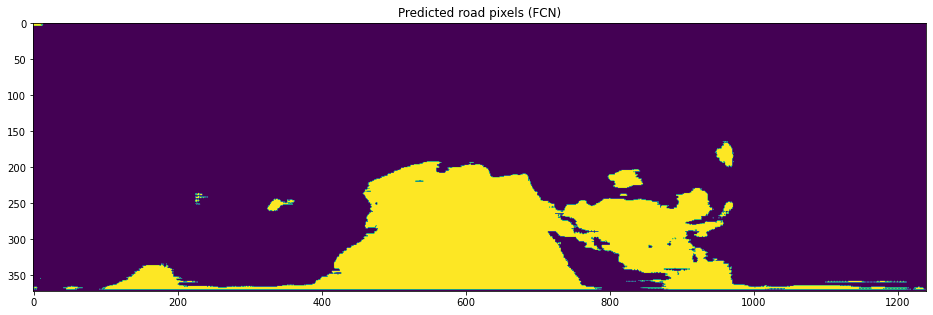

In [48]:
img = (left_imgs[num]/255) - 0.5
mag = mags[num]
mag = (mag/np.max(mag)) - 0.5
LoG = LoGs[num]
LoG = (LoG/np.max(LoG)) - 0.5
depth = depths[num]
depth = (depth/np.max(depth)) - 0.5
features = np.dstack((img, mag, LoG, depth))[:-3, :-2, :]

inp = np.expand_dims(features, axis=0)
inp = np.transpose(inp, (0, 3, 2, 1))
out = fcn_road_classifier(torch.Tensor(inp).to(device))

pred = out.argmax(dim=1).permute(2, 1, 0).squeeze().cpu().numpy()
plt.imshow(pred)
plt.title("Predicted road pixels (FCN)")

We can see that the prediction is more accurate, and the above cell runs almost instantly (even on a CPU).

## Part 4) Fitting a plane in 3D to road pixels 

Worked on by Charbel and Rahul

compute3Dpoints() calculates the 3D coordinates of each pixel within the image and depth map to be used later on to plot each pixel in 3D to form a 3D point cloud. We are able to achieve this because we are given our depth values from the depth map which is also our $Z$ value where $$ Z = \frac{f*T}{x_{r}-x_{l}}$$ where $x_{r}-x_{l}$ is the disparity provided by our disparity map and $f$ and $T$ is provided through our camera parameters. Knowing this we can compute the corresponding $X$ and $Y$ values where $X = \frac{Z*(row - p_{x})}{f}$ and $Y=\frac{Z*(col -p_{y})}{f}$, where $P_{x}$ and $p_{y}$ are the principal points, "row" is the row of the pixel, and "col" is the column of the pixel we are trying to compute the 3D coordinates for.

In [54]:
def compute3Dpoints(depthMap, disparity, imgL, k, pred, top_left=None, bottom_right=None, mark_road_pixels=False):
    #output will be array of coordinates same size as depth map 
    i, j = depthMap.shape
    output, rgb, road_pixels = [], [], []
    K = np.linalg.inv(k)
    
    conv_y = py / (i/2)
    conv_x = px / (j/2)
    
    for row in range(i-4, 0, -1):
        for col in range(j-5):
            if disparity[row][col] != 0:
                
                coord = np.array([row, col, 1])
                coordRGB = np.array([imgL[row][col][0], imgL[row][col][1], imgL[row][col][2]])/255 
                #scale homogenous coord by depth
                coord = depthMap[row][col] * coord
                #get 3d coord
                coord3D = (K @ coord)
                coord_final = np.array([coord3D[0],coord3D[2],coord3D[1]])
                
                if pred[row, col] == 1:
                    if mark_road_pixels:
                        coordRGB = np.array((255, 0, 0))
                    road_pixels.append(coord_final)
                
                if top_left != None and bottom_right != None:
                    left_x, left_y = top_left
                    right_x, right_y = bottom_right
                    if left_y <= row <= right_y and left_x <= col <= right_x:  
                        output.append(coord_final)
                        rgb.append(coordRGB)
                else:
                    output.append(coord_final)
                    rgb.append(coordRGB)
                
    return (output, rgb, road_pixels)

points, rgb, road_pixels = compute3Dpoints(depths[num], 
                              compute_disparity(left[:, :, 0], right[:, :, 0], num_disp=192), 
                              left[:, :, ::-1], 
                              K, pred, mark_road_pixels=False)

We use the Open3D library to visualize the 3D point cloud.

In [55]:
# This plots the 3D point cloud in a new window
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(rgb)
o3d.visualization.draw_geometries([pcd])

To fit the a linear plane to the road, we used a combination of least squares and RANSAC for robustness.

First, we need use our model from part 3) to identify road pixels and compute their 3D coordinates. This is handled by the compute3Dpoints() function in part 2). We can visualize the road pixels in 3D by setting the optional argument 'mark_road_pixels' to True.

Without the road marked:
<img src="./clean.png" width="600">

With the road marked:
<img src="./road1.png" width="500">
<img src="./road2.png" width="500">



Given to points, say $x$ and $y$, we want to be able to predict a value $z$ with the formula $xw_0 + yw_1 + w_2 = z$.

Our task is to find values $w_0, w_1, w_2$

This can be rewritten as $ \begin{bmatrix}
x & y & 1\\
\end{bmatrix} \begin{bmatrix}
w_0 \\
w_1 \\
w_2 \\
\end{bmatrix} = z$

So for $N$ data points we would solve

$$\begin{bmatrix}
x_0 & y_0 & 1\\
x_0 & y_0 & 1\\
...\\
x_N & y_N & 1\\
\end{bmatrix} \begin{bmatrix}
w_0 \\
w_1 \\
w_2 \\
\end{bmatrix} = \begin{bmatrix}
z_0 \\
z_1 \\
... \\
z_N
\end{bmatrix}$$

Here are the functions that apply the least squares formula and RANSAC

In [51]:
def least_squares(x, t):
    
    # Constructing data matrix X
    biases = np.ones((x.shape[0], 1))
    X = np.concatenate((x, biases), axis=1)
    
    # Computing (X^T * X)^(-1) * X^T * t
    return np.linalg.inv(X.T @ X) @ X.T @ t

In [52]:
def RANSAC(plane_data):
    
    Ws = []

    # RANSAC
    # We set S=3000 as that would give approximately 99% of success assuming 20% of matches are outliers
    # => log(1-0.99)/log(1-0.2^4) approx = 3000
    for i in range(60):
        
        # Taking points randomly
        rand_points = np.stack(random.sample(plane_data, 100))
        
        # Compute least squares estimation for random points
        w = least_squares(np.concatenate((rand_points[:, 0:1], rand_points[:, 2:]), axis=1), rand_points[:, 1:2])
        
        # Count inliers
        inliers = 0
        for j in range(len(plane_data)):
            x, z, y = plane_data[j]
            pred = np.array([x, y, 1]) @ w
            if np.linalg.norm(plane_data[j] - np.array([x, pred[0], y])) < 10:
                inliers += 1
        
        Ws.append((w, inliers))
    
    # Retun the weights with most inliers
    return max(Ws, key=lambda x:x[1])[0]

In [53]:
# This takes a few minutes to run, so we ran it with less than 3000 iterations
w = RANSAC(road_pixels)

We now have $w_0, w_1, w_2$ which define our plane.

## Part 5) Plotting the 3D and the estimated ground plane

Worked on by Charbel

This function gives us a large square populated densely with points that are then projected on the plane for plotting.

In [61]:
def get_plane_points(min_bound, max_bound, density, w):
    
    Xs = np.linspace(min_bound, max_bound, density)
    Ys = np.linspace(min_bound, max_bound, density)
    
    plane, colors = [], []
    X, Y = np.meshgrid(Xs,Ys)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x, y = X[i, j], Y[i, j]
            coords = np.array([x, y, 1])
            pred_z = coords @ w
            plane.append(np.array([x, pred_z[0], y]))
            colors.append(np.array([0, 0, 255]))
            
    return plane, colors
    
plane, colors = get_plane_points(-90000, 90000, 500, w)

Plots the 3D point cloud as well as the plane

In [62]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points + plane)
pcd.colors = o3d.utility.Vector3dVector(rgb + colors)
o3d.visualization.draw_geometries([pcd])

We get the following results
<img src="./road3.png" width="600">
<img src="./road4.png" width="600">
<img src="./road5.png" width="600">

## Part 6) Pre-trained model and object detector to detect cars in images

Worked on by Rahul

Code was retrieved from https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb

To detect cars in images, instead of using the pre-trained models provided by KITTI, we opted to use another pre-trained model provided through tensor-flow because of complications arising when using the KITTI dataset. The pre-trained model and inferencing code was provided through the tensor-flow object detection tutorial.

In [84]:
#import object detection module
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [85]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [86]:
#model loader
def load_model(model_name):
    
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))

    return model

### Loading label map

To use this dataset, we need to load a label map which will be used during inferencing to label the detected objects within the image. This allows us to manipulate the code in a way where we were able to extract only the information that was necessary for this project.

In [87]:
# List of the strings that is used to add correct label for each box.
#change path on diff pc
PATH_TO_LABELS = '/Users/charbel/University/U of T/Fourth Year/CSC420/Final Project/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

We use this directory to get image paths for images we want to detect cars in

In [88]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/Users/charbel/University/U of T/Fourth Year/CSC420/Final Project/models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/Users/charbel/University/U of T/Fourth Year/CSC420/Final Project/models/research/object_detection/test_images/image1.jpg')]

### Detection

Here we load in the pre-trained coco model. We opted to use this model as it is also very reliable in detecting objects like cars. This model uses the Single Shot Multibox Detector (SSD) to detect objects within images. SSD is able to detect objects by first extracting feature maps, and then applying various convulution filters to detect objects. To be precise, SSD uses VGG16, which is a convulutional neural network model developed by K. Simonyan and A. Zisserman. This model contains 13 convolution layers, subdivided into 5 groups with max pooling in each layer. The SSD detector uses the Conv4-3 layer to detect objects, and makes object predictions with their corresponding bounding boxes. The highest value prediction is then chosen for the bounded object.

<img src="./vgg16.png" width="600">

In [89]:
#loading object detection model
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [90]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


### This is what the model will return from images 

The model outputs a dictionary with four arrays that give the nessessary information to visualize a detected object. We used "detection_scores" which contains information of the how accurate the model is in determining the object and "detection_boxes" which are the corresponding bounding boxes for the detected objects.

In [91]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_scores': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32}

In [92]:
detection_model.signatures['serving_default'].output_shapes

{'detection_scores': TensorShape([None, 100]),
 'detection_classes': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'detection_boxes': TensorShape([None, 100, 4])}

The run_inference_for_single_image() function lets us run the SSD model inferencing on a given image, and manipulate the output of the object detections

In [93]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]
    
    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)
    
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
        
    return output_dict

Using the object detection code, we were able to manipulate the show_inference() function in such a way that the output of the model and its inferencing would be a dictionary of deteced car objects and thier corresponsing bounding boxes. The function would output all "detecion_scores" and "detection_boxes" that corresponds to the car object in "detection_classes", which is given the value 3.

In [94]:
def show_inference(model, image_path):
    
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    
    #output only car detection data as array
    cars = []
    
    for i in range(len(output_dict['detection_classes'])):
        if output_dict['detection_classes'][i] == 3:
            
            car_tup = (output_dict['detection_scores'][i], output_dict['detection_boxes'][i])
            
            cars.append(car_tup)

    return cars

In [95]:
for image_path in TEST_IMAGE_PATHS:
    car = show_inference(detection_model, image_path)
car[:2]

[(0.94161856,
  array([0.47820097, 0.14090064, 0.99156445, 0.37478575], dtype=float32)),
 (0.6362827,
  array([0.4681147 , 0.48846352, 0.5154988 , 0.51276505], dtype=float32))]

### Visualize data

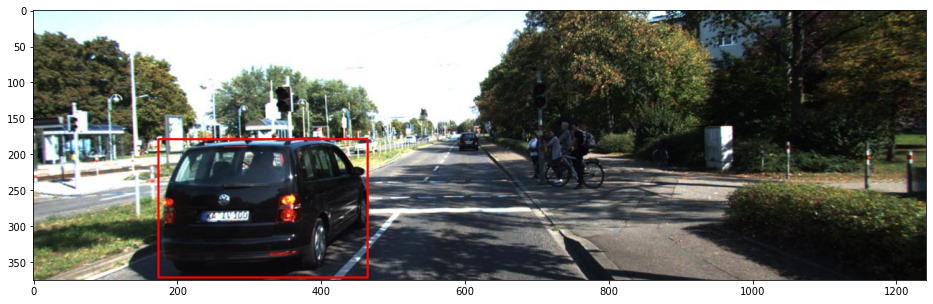

In [96]:
def visualize(model_output, img_path):
    
    boxes = []
    img = cv2.cvtColor(cv2.imread((str)(img_path)), cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape
    
    min_score_thresh=.8
    
    for i in range(len(model_output)):
        if model_output[i][0] > min_score_thresh:
        
            coord = (int(model_output[i][1][0] * height), int(model_output[i][1][1] * width), 
                     int(model_output[i][1][2] * height), int(model_output[i][1][3] * width))
            start = (coord[1], coord[0])
            end = (coord[3],coord[2])
            
            boxes.append((start, end))
        
            thickness = 2
            color = (255,0,0)
        
            img = cv2.rectangle(img, start, end, color, thickness)
        
    return img, boxes


for im_path in TEST_IMAGE_PATHS:
    image, boxes = visualize(car, im_path)
    plt.imshow(image)
    #plt.show()

## Part 7) Viewpoint detector 

Worked on by Charbel

First, we need to load the data found in the 'train_angle' folder and convert the angles to 12 classes with 30 degree increments.

In [47]:
directory = "./project2/train_angle"

def get_viewpoint_data(directory):
    
    viewpoint_data, viewpoint_labels = [], []
    
    # Looping through all matlab files
    for filename in sorted(os.listdir(directory + "/labels")):
        if filename.endswith(".mat"):

            # Extracting image number
            file_num = filename.split(".")[0]

            # Loading matlab data
            data = loadmat(os.path.join(directory + "/labels", filename))["annotation"]

            # Loading corresponding image
            img = cv2.imread(directory + "/image/" + file_num + ".jpg")

            # Extracting needed data
            classes = data["class"][0][0][0]
            truncated = data["truncated"][0][0][0]
            occlusion = data["occlusion"][0][0][0]
            bboxes = data["bboxes"][0][0]
            orient = data["orient"][0][0]

            # Loop over each detection
            for i in range(len(classes)):
                
                # As per the README file, we ignore objects marked "DontCare" and those with
                # truncated > 0.3 and occluded > 2
                if classes[i][0] == "Car" and truncated[i][0][0] <= 0.3 and occlusion[i][0][0] <= 2:
                    
                    # Extracting the bounding box coordinates
                    left_x, top, width, height = bboxes[i].astype(int)
                    viewpoint = orient[i][0]
                    
                    # Cropping the image to only include the bounded car
                    car = img[top:top+height, left_x:left_x+width, :]
                    resized_car = cv2.resize(car, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
                    resized_car = (resized_car/255) - 0.5
                    resized_car = np.transpose(resized_car, (2, 1, 0))
                    viewpoint_data.append(resized_car)
                    
                    # Getting the labels within certain angles with 30 degress increment
                    v_label = 0
                    if 0 <= viewpoint < 15 or 345 < viewpoint <= 360:
                        v_label = 0
                    elif 15 <= viewpoint < 45:
                        v_label = 1
                    elif 45 <= viewpoint < 75:
                        v_label = 2
                    elif 75 <= viewpoint < 105:
                        v_label = 3
                    elif 105 <= viewpoint < 135:
                        v_label = 4
                    elif 135 <= viewpoint < 165:
                        v_label = 5
                    elif 165 <= viewpoint < 195:
                        v_label = 6
                    elif 195 <= viewpoint < 225:
                        v_label = 7
                    elif 225 <= viewpoint < 255:
                        v_label = 8
                    elif 255 <= viewpoint < 285:
                        v_label = 9
                    elif 285 <= viewpoint < 315:
                        v_label = 10
                    elif 315 <= viewpoint < 345:
                        v_label = 11
                    viewpoint_labels.append(v_label)
                    
    return viewpoint_data, viewpoint_labels


In [49]:
viewpoint_data, viewpoint_labels = get_viewpoint_data(directory)

In [52]:
viewpoint_data = np.stack(viewpoint_data)
viewpoint_labels = np.stack(viewpoint_labels)
print(viewpoint_data.shape)
print(viewpoint_labels.shape)

(949, 3, 224, 224)
(949,)


Splitting data into training and validation set

In [53]:
Xtrain, Ttrain = viewpoint_data[:820], viewpoint_labels[:820]
Xval, Tval = viewpoint_data[820:], viewpoint_labels[820:]

### Attempt #1  A Regular CNN

Initially, we trained a vanilla CNN that took in an image stacked with its LoG along the channel dimension. However, that model was only able to achieve around 60% validation accuracy. After multiple attempts at hyperparameter tuning, we decided to try another approach. The class for the unsucceful CNN is included below, and can be trained using the train_model() function that we will go through in a bit. 

Note: To train ViewpointCNN we would need to modfiy get_viewpoint_data() to include LoG

In [ ]:
class ViewpointCNN(nn.Module):
    def __init__(self, n=4):
        super(ViewpointCNN, self).__init__()
                
        self.n = n
                
        self.conv1 = nn.Conv2d(in_channels=4,
                               out_channels=n,
                               kernel_size=3,
                               padding=1)
                
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=n, 
                               out_channels=n*2, 
                               kernel_size=3, 
                               padding=1)
                
        self.conv3 = nn.Conv2d(in_channels=n*2, 
                               out_channels=n*4,
                               kernel_size=3,
                               padding=1)

        
        self.conv4 = nn.Conv2d(in_channels=n*4, 
                               out_channels=n*2,
                               kernel_size=3,
                               padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=n*2, 
                               out_channels=n,
                               kernel_size=3,
                               padding=1)
        
        self.leaky = nn.LeakyReLU()
                
            
        self.fc1 = nn.Linear(n*2*28*28, 100)
        self.fc2 = nn.Linear(100, 12)
        
        
    def forward(self, x):        
        x = self.pool(self.leaky(self.conv1(x)))        
        x = self.pool(self.leaky(self.conv2(x)))        
        x = self.pool(self.leaky(self.conv3(x)))        
        x = self.leaky(self.conv4(x))
        x = x.view(-1, self.n*2*28*28)
        x = torch.relu(self.fc1(x))
        x = x.view(-1, 100)
        return self.fc2(x)  

### Attempt #2 Transfer Learning 

Resources used for this section:

https://www.pluralsight.com/guides/introduction-to-resnet by Gaurav Singhal (2020)

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035 by Vincent Feng (2017)

https://medium.com/@waya.ai/deep-residual-learning-9610bb62c355 by Michael Dietz (2017)

ResNet is a deep residual network where the features from the previous layers are passed through to prevent the network's gradient from vanishing:


<img src="./resneetdia.png" width="300">

For our transfer learning task, we reuse the architecture and parameters of ResNet to as a starting point, and add to it our fully connected layer with 12 outputs for our classification task. We then train the model with our data.

In [54]:
from torchvision import *
net = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/charbel/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.5MB/s]


In [ ]:
# Adding our fully connected layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 12)

In [57]:
def get_viewpoint_accuracy(model, X, T):
    model.eval()
    pred = model(X).argmax(dim=1).cpu().numpy()
    return np.mean(pred==T.cpu().numpy())

#### This model was also trained on Google Colab to utilize GPU 

In [ ]:
def train_model(model, X, T, Xval, Tval, batch_size=10, weight_decay=1e-5, learning_rate=0.001, num_epochs=100, 
                checkpoint_path=None):
    
    # Defining our loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=weight_decay) 
    
    # Initializing lists to store performance data
    iters, train_loss, train_accs, val_accs = [], [], [], []
    
    # Move model and arrays to GPU (if possible)
    model = model.to(device)
    X = torch.Tensor(X).to(device)
    T = torch.Tensor(T).long().to(device)
    Xval = torch.Tensor(Xval).to(device)
    Tval = torch.Tensor(Tval).long().to(device)

    n = 0
    for epoch in range(num_epochs):
        
        # Shuffle data at each epoch
        s = np.arange(X.shape[0])
        np.random.shuffle(s)
        X = X[s]
        T = T[s]
        
        # Splitting data into batches
        N, C, W, H = X.shape
        Xbatches = X.reshape(N//batch_size, batch_size, C, W, H)
        Tbatches = T.reshape(N//batch_size, batch_size)
        
        for i in range(N//batch_size):
            
            # Extract current batch
            batch = Xbatches[i]
            target = Tbatches[i]
            
            # Annotate model for training
            model.train()
            
            # Forward pass
            out = model(batch)
            
            # Backpropagation
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1
        
        # Checkpointing parameters
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch), _use_new_zipfile_serialization=False)
            
        # Computing accuracies and loss
        train_acc = get_viewpoint_accuracy(model, X[:300], T[:300])
        val_acc = get_viewpoint_accuracy(model, Xval, Tval)
        loss = float(loss)/batch_size
        print("Epoch %d; Loss %f; Train acc %f; Val acc %f" % (epoch+1, loss, train_acc, val_acc))

        iters.append(n)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_loss.append(loss)
    
    # Plotting
    plt.title("Learning Curve") 
    plt.plot(iters, train_loss, label="Train") 
    plt.xlabel("Iterations") 
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_accs)
    plt.plot(iters, val_accs, c="r") 
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy") 
    plt.show()

train_model(net, Xtrain, Ttrain, Xval, Tval, checkpoint_path="/content/gdrive/My Drive/CSC420/vp_weights/ckpt-{}.pk")

Here are our results
<img src="./res3.png" width="400">
<img src="./res1.png" width="400">
<img src="./res2.png" width="400">

By adding our fully connected layer to ResNet and by starting with their pretrained weights, we were able to train the model to about 87% validation accuracy, this is a huge improvement over the 60% validation in our first attempt.

## Part 8) Estimated viewpoint arrow and bounding box

Worked on by Rahul

In [168]:
net.load_state_dict(torch.load('./ckpt-39.pk', map_location=torch.device('cpu')))

<All keys matched successfully>

In [189]:
#given img_path and model_output, visualize the bounding box of cars and their viewpoints indicated by an arrow
def visualizee(vp_net, model_output, img_path):
    #get image and convert to rgb
    img = cv2.cvtColor(cv2.imread((str)(img_path)), cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    #thresh rate for drawing bounding box
    min_score_thresh=.5
    #angles for given viewpoints
    angles_dict = {0:0,1:30,2:60,3:90,4:120,5:150,6:180,7:210,8:240,9:270,10:300,11:330,12:360}
    
    for i in range(len(model_output)):
        #only draw bounding boxes if accuracy > thresh score
        if model_output[i][0] > min_score_thresh:
        
            #compute bounding box coordinates for use by cv2
            coord = (int(model_output[i][1][0] * height), int(model_output[i][1][1] * width), 
                     int(model_output[i][1][2] * height), int(model_output[i][1][3] * width))
            start = (coord[1], coord[0])
            end = (coord[3],coord[2])
            
            #compute angles for every viewpoint
            l = int((end[1]-start[1])//3)
            t = int((end[0]-start[0])//3)
            angles_dir = {0:(int((end[0]+start[0])//2), end[1]),
                          30:((t)+start[0], end[1]),
                          60:(start[0], (3*l)+ start[1]),
                          90:(start[0], (int((end[1]-start[1])//2))+ start[1]),
                          120:(start[0], (l)+ start[1]),
                          150:((t)+start[0], start[1]),
                          180:(int((end[0]-start[0])//2), start[1]),
                          210:((3*t)+start[0], start[1]),
                          240:(end[0], (l)+ start[1]),
                          270:(end[0], (int((end[1]-start[1])//2))+ start[1]),
                          300:(end[0], (3*l)+ start[1]),
                          330:((3*t)+start[0], end[1]),
                          360:(int((end[0]+start[0])//2), end[1])}
            
            #get car bounding box img
            view_img = img[start[1]:end[1]+1 , start[0]:end[0]+1]
            
            resized_car = cv2.resize(view_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            resized_car = (resized_car/255) - 0.5
            resized_car = np.expand_dims(resized_car, axis=0)
            resized_car = np.transpose(resized_car, (0, 3, 2, 1))
            
            
            #detect viewpoint
            output = vp_net(torch.Tensor(resized_car))
            angle = angles_dict[output.argmax().item()]
                                
            #origin of arrow
            x, y = (int((end[0]+start[0])//2), int((end[1]+start[1])//2))
            
            thickness = 2
            color = (255,0,0)
            
            #draw bounding box
            img = cv2.rectangle(img, start, end, color, thickness)
            #draw arrow
            img = cv2.arrowedLine(img, (x,y), angles_dir[angle],
                                     color, thickness)
    #draw arrow and display image
    #fig,ax = plt.subplots(1, figsize=(15, 15))
    #ax.set_aspect('equal')
    plt.imshow(img)

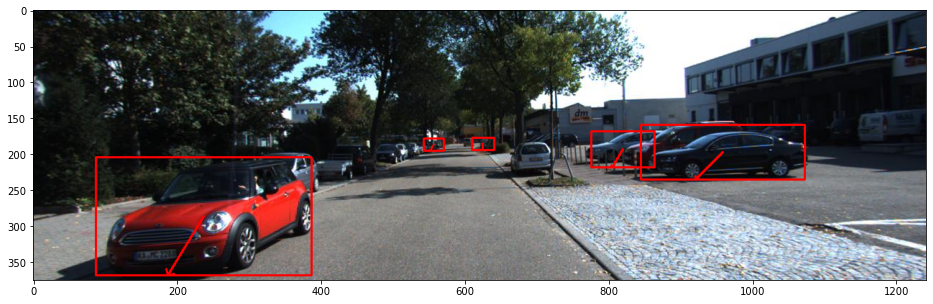

In [190]:
matplotlib.rcParams['figure.figsize'] = (16, 20)
for im_path in TEST_IMAGE_PATHS:
    visualizee(net, car, im_path)

## Part 9) 3D Bounding Box

Worked on by Charbel

The top down view approach was inspired from this paper by Königshof et al.

https://www.mrt.kit.edu/z/publ/download/2019/Koenigshof2019Objects.pdf

We start by stacking our data.

In [97]:
stacked = np.stack(points)
stacked.shape

(367628, 3)

In [98]:
matplotlib.rcParams['figure.figsize'] = (7, 7)

Let's look at the scene from above to see if we can identify any clusters of objects.

Text(0.5, 1.0, 'A top down view of the scene')

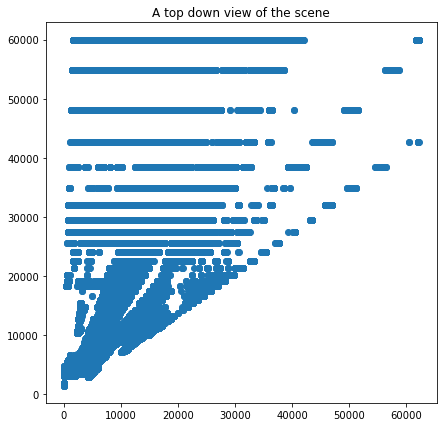

In [99]:
plt.scatter(stacked[:, 2], stacked[:, 1])
plt.title("A top down view of the scene")

It's difficult to identify objects this way, so we only consider the points in the bounding boxes for clustering. The code below computes the 3D coordinates for points inside the bounding boxes

In [100]:
bpoints, rgbs = [], []
for l, r in boxes:
    bounded, bounded_rgb, _ = compute3Dpoints(depths[num],
                                     compute_disparity(left[:, :, 0], right[:, :, 0], num_disp=192),
                                     left[:, :, ::-1], 
                                     K, pred, mark_road_pixels=False,
                                     top_left=l, bottom_right=r
                                    )
    bpoints += bounded
    rgbs += bounded_rgb

We can visualize the output in 3D with code below

In [72]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(bpoints)
pcd.colors = o3d.utility.Vector3dVector(rgbs)
o3d.visualization.draw_geometries([pcd])

<img src="./bound1.png" width="400">

We can see that most of the image is gone, here's what it looks like from the top.

Text(0, 0.5, 'Z')

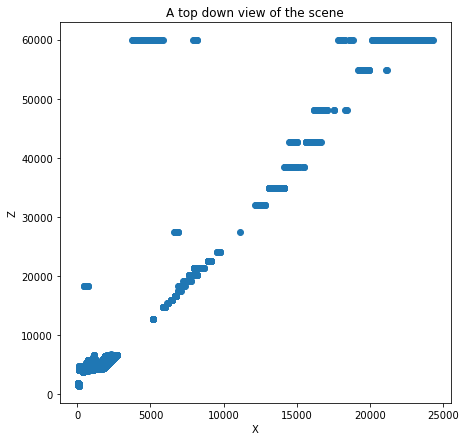

In [101]:
bpoints = np.stack(bpoints)
plt.scatter(bpoints[:, 2], bpoints[:, 1])
plt.title("A top down view of the scene")
plt.xlabel("X")
plt.ylabel("Z")

In [102]:
top_data = np.concatenate((bpoints[:, 2:], bpoints[:, 1:2]), axis=1)

This function plots the clusters to help us visualize what is going on.

In [103]:
def plot_clusters(X, labels):

    plot_colors = []
    plt.figure()
    noise_color = max(labels)+1
    
    for i in range(len(X)):
        if labels[i] != -1:
            plot_colors.append(labels[i])
        else:
            plot_colors.append(noise_color)
    plt.scatter(X[:, 0], X[:, 1], c=plot_colors, s=5)


DBSCAN resource used:

https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556#:~:text=DBSCAN%20stands%20for%20density%2Dbased,many%20points%20from%20that%20cluster by Soner Yıldırım (2020)

In order to cluster our points into seperate cars, we opted to use the DBSCAN clustering algorithm, a density based algorithm that could potentially help us detect objects of arbitrtary shapes and detect outliers more efficiently.

DBSCAN starts at a random point and goes through the data and places points as part of the same cluster if they are "eps" units away from eachother. That is, the threshold distance the determines whether DBSCAN has entered a new neighbourhood is "eps". Another important parameter is "min_samples", which is the minimum number of points needed to define a cluster and the minimum number of points that need to be surrounding another point for it not to be considered noise. 

In [104]:
from sklearn.cluster import DBSCAN
from collections import Counter

def get_cluster_points(top_data):
    
    clustering = DBSCAN(eps=250, min_samples=10).fit(top_data)
    
    # Visualizee clusters
    plot_clusters(top_data, clustering.labels_)
    
    # Count the number of points that belong to each cluster
    occurences = dict(Counter(clustering.labels_))
    
    # Sort the clusters in descending order
    max_clusters = sorted(occurences, key=occurences.get, reverse=True)[:len(boxes)]
    
    cluster_points = defaultdict(list)
    for cluster in max_clusters:
        for i in range(len(clustering.labels_)):
            if clustering.labels_[i] == cluster:
                cluster_points[cluster].append(bpoints[i])
    
    return cluster_points
    

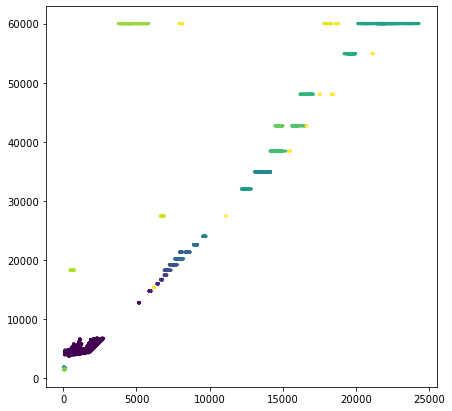

In [105]:
cluster_points = get_cluster_points(top_data)

We can see from the above plot that the car has been successfully clustered while the rest of the points we deemed as part of another cluster or as noise. We now need to find the best fit bouding box for it. 

For this, we use the following algorithm which leverages the fact that the minimum bounding rectangle has the same orientation as one one of the edges the convex hull (the smallest convex set that contains the point cloud). So the algorithm basically checks every possible rotation for each edge and returns the one with the minimum area. This is known as the Calliper algorithm.

Code retrieved from 

https://github.com/dbworth/minimum-area-bounding-rectangle/blob/master/python/min_bounding_rect.py by David Butterworth (2013)

And links that helped us understand how it works:

https://gis.stackexchange.com/questions/22895/finding-minimum-area-rectangle-for-given-points
https://www.datagenetics.com/blog/march12014/index.html


In [106]:
# Find the minimum-area bounding box of a set of 2D points
#
# The input is a 2D convex hull, in an Nx2 numpy array of x-y co-ordinates. 
# The first and last points points must be the same, making a closed polygon.
# This program finds the rotation angles of each edge of the convex polygon,
# then tests the area of a bounding box aligned with the unique angles in
# 90 degrees of the 1st Quadrant.
# Returns the 
#
# Tested with Python 2.6.5 on Ubuntu 10.04.4
# Results verified using Matlab

# Copyright (c) 2013, David Butterworth, University of Queensland
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#     * Neither the name of the Willow Garage, Inc. nor the names of its
#       contributors may be used to endorse or promote products derived from
#       this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

from numpy import *
import sys  # maxint

def minBoundingRect(hull_points_2d):
    #print "Input convex hull points: "
    #print hull_points_2d

    # Compute edges (x2-x1,y2-y1)
    edges = zeros( (len(hull_points_2d)-1,2) ) # empty 2 column array
    for i in range( len(edges) ):
        edge_x = hull_points_2d[i+1,0] - hull_points_2d[i,0]
        edge_y = hull_points_2d[i+1,1] - hull_points_2d[i,1]
        edges[i] = [edge_x,edge_y]
    #print "Edges: \n", edges

    # Calculate edge angles   atan2(y/x)
    edge_angles = zeros( (len(edges)) ) # empty 1 column array
    for i in range( len(edge_angles) ):
        edge_angles[i] = math.atan2( edges[i,1], edges[i,0] )
    #print "Edge angles: \n", edge_angles

    # Check for angles in 1st quadrant
    for i in range( len(edge_angles) ):
        edge_angles[i] = abs( edge_angles[i] % (math.pi/2) ) # want strictly positive answers
    #print "Edge angles in 1st Quadrant: \n", edge_angles

    # Remove duplicate angles
    edge_angles = unique(edge_angles)
    #print "Unique edge angles: \n", edge_angles

    # Test each angle to find bounding box with smallest area
    min_bbox = (0, sys.maxsize, 0, 0, 0, 0, 0, 0) # rot_angle, area, width, height, min_x, max_x, min_y, max_y
    print("Testing", len(edge_angles), "possible rotations for bounding box... \n")
    for i in range( len(edge_angles) ):

        # Create rotation matrix to shift points to baseline
        # R = [ cos(theta)      , cos(theta-PI/2)
        #       cos(theta+PI/2) , cos(theta)     ]
        R = array([ [ math.cos(edge_angles[i]), math.cos(edge_angles[i]-(math.pi/2)) ], 
                   [ math.cos(edge_angles[i]+(math.pi/2)), math.cos(edge_angles[i]) ] ])
        #print "Rotation matrix for ", edge_angles[i], " is \n", R

        # Apply this rotation to convex hull points
        rot_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
        #print "Rotated hull points are \n", rot_points

        # Find min/max x,y points
        min_x = nanmin(rot_points[0], axis=0)
        max_x = nanmax(rot_points[0], axis=0)
        min_y = nanmin(rot_points[1], axis=0)
        max_y = nanmax(rot_points[1], axis=0)
        #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

        # Calculate height/width/area of this bounding rectangle
        width = max_x - min_x
        height = max_y - min_y
        area = width*height
        #print "Potential bounding box ", i, ":  width: ", width, " height: ", height, "  area: ", area 

        # Store the smallest rect found first (a simple convex hull might have 2 answers with same area)
        if (area < min_bbox[1]):
            min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )
        # Bypass, return the last found rect
        #min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )

    # Re-create rotation matrix for smallest rect
    angle = min_bbox[0]   
    R = array([ [ math.cos(angle), math.cos(angle-(math.pi/2)) ], [ math.cos(angle+(math.pi/2)), math.cos(angle) ] ])
    #print "Projection matrix: \n", R

    # Project convex hull points onto rotated frame
    proj_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
    #print "Project hull points are \n", proj_points

    # min/max x,y points are against baseline
    min_x = min_bbox[4]
    max_x = min_bbox[5]
    min_y = min_bbox[6]
    max_y = min_bbox[7]
    #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

    # Calculate center point and project onto rotated frame
    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_point = dot( [ center_x, center_y ], R )
    #print "Bounding box center point: \n", center_point

    # Calculate corner points and project onto rotated frame
    corner_points = zeros( (4,2) ) # empty 2 column array
    corner_points[0] = dot( [ max_x, min_y ], R )
    corner_points[1] = dot( [ min_x, min_y ], R )
    corner_points[2] = dot( [ min_x, max_y ], R )
    corner_points[3] = dot( [ max_x, max_y ], R )
    #print "Bounding box corner points: \n", corner_points

    #print "Angle of rotation: ", angle, "rad  ", angle * (180/math.pi), "deg"

    return (angle, min_bbox[1], min_bbox[2], min_bbox[3], center_point, corner_points) 
# rot_angle, area, width, height, center_point, corner_points

We now use the algorithm to find the minimum bounding rectangle. Since our input is in 2D, so is the output.
We only know the bounds with respect to $X$ and $Z$, but using our ground plane equation, we can infer Y, we just need to rewrite $$Xw_1 + Yw_2 + w_3 = Z \Rightarrow Y = \frac{Z - Xw_1 - b}{w_2}$$

Once we get our value for $Y$, we know where our points are on the ground. If we assume that most cars are around 1.7 to 2 meters high, we can then find our rectangle that bounds to top of the car. Finally, we can connect all the lines together and display the 3D bounding box.

Testing 4233 possible rotations for bounding box... 



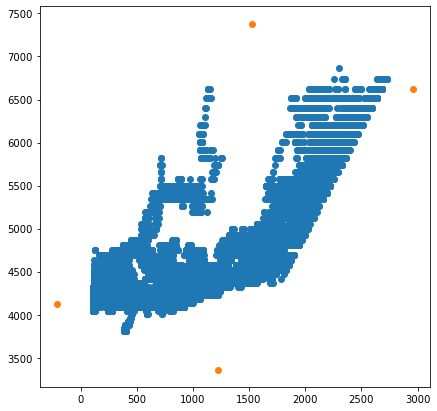

In [107]:
def find3Dbounds(cluster_points):
    
    all_bounds = []
    for c, c_p in cluster_points.items():
        stacked_cp = np.stack(c_p)
        _, _, _, _, _, t = minBoundingRect(np.concatenate((stacked_cp[:, 2:], stacked_cp[:, 1:2]), axis=1))

        # Visualizing result around hypothesized car
        plt.scatter(stacked_cp[:, 2], stacked_cp[:, 1])
        plt.scatter(t[:,0], t[:, 1])
        #plt.show()

        # Finding projection onto plane
        X = t[:, 0:1]
        Z = t[:, 1:2]
        Y = (Z - X*w[1] - w[2])/w[0]

        bound1 = np.concatenate((Y, t[:, 1:2], t[:, 0:1]), axis=1).tolist()
        bound2 = np.concatenate((Y - 1700, t[:, 1:2], t[:, 0:1]), axis=1).tolist()
        
        all_bounds.append((bound1, bound2))
        
    return all_bounds

all_bounds = find3Dbounds(cluster_points)

In [108]:
def plot_3D(all_bounds):
    pcd_points, pcd_colors, line_sets = stacked.tolist(), rgb, []

    for bound1, bound2 in all_bounds:
        final_points = bound1 + bound2
        lines = [[0, 1], [0, 3], [0, 4], [1, 2], [1, 5], [2, 3], [3, 2], 
                 [4, 5], [4,7], [5, 6], [6, 7], [2, 6], [3, 7]]
        colors = [[1, 0, 0] for i in range(len(lines))]

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(final_points)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector(colors)

        line_sets.append(line_set)


        pcd_points += bound1 + bound2
        pcd_colors += [np.array([1, 0, 0])]*8


    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcd_points)
    pcd.colors = o3d.utility.Vector3dVector(rgb)
    o3d.visualization.draw_geometries(line_sets + [pcd])
    
plot_3D(all_bounds)

### Results 

<img src="./b1.png" width="400">
<img src="./b2.png" width="400">

We can see that in this particular example, the algorithm does quite well and encapsulates the car to reasonable degree of accuracy. However, there are some failure cases:

<img src="./b3.png" width="400">
<img src="./b4.png" width="600">

We can see that DBSCAN mistaked a dense patch of road for a car, this can be confirmed by looking at the top down view:

<img src="./b5.png" width="400">

The green cluster is the one that fooled it. Also, the orientation of the 3D box around the black car in the last image is not quite right, suggesting that the minimum area bounding rectangle is not always the best solution, to counteract this, improvements can be made by taking the viewpoint into account.

## All References 

DeveloperDeveloper 3 et al. 1961. Finding minimum-area-rectangle for given points? (January 1961). Retrieved April 16, 2021 from https://gis.stackexchange.com/questions/22895/finding-minimum-area-rectangle-for-given-points [1] 

Anon. Bounding Boxes. Retrieved April 16, 2021 from https://www.datagenetics.com/blog/march12014/index.html [2] 

Dbworth. 2013. dbworth/minimum-area-bounding-rectangle. (February 2013). Retrieved April 16, 2021 from https://github.com/dbworth/minimum-area-bounding-rectangle/blob/master/python/min_bounding_rect.py [3] 

Soner. 2020. DBSCAN Clustering - Explained. (April 2020). Retrieved April 16, 2021 from https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556#:~:text=DBSCAN%20stands%20for%20density%2Dbased,many%20points%20from%20that%20cluster [4] 

Hendrik Königshof, Niels Ole Salscheider, Christoph Stiller, Realtime 3D Object Detection for Automated Driving Using Stereo Vision and Semantic Information. Retrieved April 16, 2021 from https://www.mrt.kit.edu/z/publ/download/2019/Koenigshof2019Objects.pdf [5] 

Gaurav Singhal. 2020. Gaurav Singhal. (May 2020). Retrieved April 16, 2021 from https://www.pluralsight.com/guides/introduction-to-resnet [6] 

Vincent Feng. 2017. An Overview of ResNet and its Variants. (July 2017). Retrieved April 16, 2021 from https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035 [7] 

Michael Dietz. 2017. Understand Deep Residual Networks - a simple, modular learning framework that has redefined... (May 2017). Retrieved April 16, 2021 from https://medium.com/@waya.ai/deep-residual-learning-9610bb62c355 [8] 

Himanshu Rawlani. 2020. Implementing a fully convolutional network (FCN) in TensorFlow 2. (October 2020). Retrieved April 16, 2021 from https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b#:~:text=FCN%20is%20a%20network%20that,connected%20layers%20(Dense%20layers [9] 

Jonathan Hui. 2020. SSD object detection: Single Shot MultiBox Detector for real-time processing. (December 2020). Retrieved April 16, 2021 from https://jonathan-hui.medium.com/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06#:~:text=SSD%20is%20a%20single%2Dshot,offsets%20to%20default%20boundary%20boxes [10] 

Jonathan Hui. 2020. SSD object detection: Single Shot MultiBox Detector for real-time processing. (December 2020). Retrieved April 16, 2021 from https://jonathan-hui.medium.com/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06 [11] 

Anon. Stereo Disparity using Semi-Global Block Matching. Retrieved April 16, 2021 from https://www.mathworks.com/help//visionhdl/ug/stereoscopic-disparity.html [12] 

Anon. 2021.(February 2021). Retrieved April 16, 2021 from https://neurohive.io/en/popular-networks/vgg16/#:~:text=VGG16%20is%20a%20convolutional%20neural%20network%20model%20proposed%20by%20K.&text=Zisserman%20from%20the%20University%20of,images%20belonging%20to%201000%20classes [13] 

Dbworth. 2013. dbworth/minimum-area-bounding-rectangle. (February 2013). Retrieved April 16, 2021 from https://github.com/dbworth/minimum-area-bounding-rectangle/blob/master/python/min_bounding_rect.py [14] 

Gaurav Singhal. 2020. Gaurav Singhal. (May 2020). Retrieved April 16, 2021 from https://www.pluralsight.com/guides/introduction-to-resnet [15] 

Soner. 2020. DBSCAN Clustering - Explained. (April 2020). Retrieved April 16, 2021 from https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556#:~:text=DBSCAN%20stands%20for%20density%2Dbased,many%20points%20from%20that%20cluster [16] 

Tensorflow. 2020. tensorflow/models. (July 2020). Retrieved April 16, 2021 from https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb [17] 